In [1]:
"""
Goal:
Optimizing conversion rate.
Build a model that predicts conversion rate and come up with ideas to improve rev.
Data:
sign-in users information during one session with each row being one user session.
"""

'\nGoal:\nOptimizing conversion rate.\nBuild a model that predicts conversion rate and come up with ideas to improve rev.\nData:\nsign-in users information during one session with each row being one user session.\n'

In [84]:
# good referce of which visualization to use
# https://www.cscu.cornell.edu/news/statnews/stnews89.pdf
# some good topic list to brush up
# https://towardsdatascience.com/why-youre-not-a-job-ready-data-scientist-yet-1a0d73f15012

## Overview of this Notebook
    1. Dataset Inspection
    2. Exploratory Data Analysis
    3. Machine Learning
    4. Conclusion

In [2]:
# Setting up
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
# Load Data
df = pd.read_csv("conversion_data.csv")

## Inspection

In [75]:
# what does the table looks like
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [4]:
# check the structure of data
print("===Summary of the dataset===")
print("# of rows: ", len(df))
print(df.dtypes)

===Summary of the dataset===
# of rows:  316200
country                object
age                     int64
new_user                int64
source                 object
total_pages_visited     int64
converted               int64
dtype: object


In [5]:
# check labels
print("# converted: {}, proportion to total population: {}%".format(len(df.loc[(df["converted"] == 1)]), round((len(df.loc[(df["converted"] == 1)])*100/len(df)),2)))
print("# not converted: {}, proportion to total population: {}%".format(len(df.loc[(df["converted"] == 0)]), round((len(df.loc[(df["converted"] == 0)])*100/len(df)),2)))

# converted: 10200, proportion to total population: 3.23%
# not converted: 306000, proportion to total population: 96.77%


In [7]:
# check the continuous variables
df[(["age","total_pages_visited"])].describe()

,age,total_pages_visited
count,316200.000000,316200.000000
mean,30.569858,4.872966
std,8.271802,3.341104
min,17.000000,1.000000
25%,24.000000,2.000000
50%,30.000000,4.000000
75%,36.000000,7.000000
max,123.000000,29.000000


In [14]:
# check categorical variables
df.describe(include = ["object"])

,country,source
count,316198,316198
unique,4,3
top,US,Seo
freq,178092,155039


In [6]:
# check missing value
df.isnull().values.any()

False

Initial inspection quick summary: 
- ~ 300k rows.
- no missing values.
- Country, source, new_user [categorical variables] with new_user being binary variable; age, total_pages_visited [numerical variables].
- converted is the label. 1: converted, 0: not converted.
- Imbalanced dataset with ~3% of sample being converted.

## Exploratory Data Analysis

Let's take a further look at each variable. Start by looking into **continuous variables**.

In [6]:
df["age"].max()

123

According to the summary above, the max age is 123, signifying some wrong inputs. So let's take a further look at their distributions with boxplot.

<mark>Notes from the book solution</mark>:  
In general, depending on the problem, you can:  
1. remove the entire row saying you don’t trust the data  
2. treat those values as NAs  
3. if there is a pattern, try to figure out what went wrong.  
In doubt, always go with removing the row. It is the safest choice.

You probably also want to emphasize in the text that wrong data is worrisome and can be an indicator of
some bug in the logging code. Therefore, you’d like to talk to the software engineer who implemented the
code to see if, perhaps, there are some bugs which affect the data significantly.   
Anyway, here is probably just **users who put wrong data**. So let’s remove them

In [8]:
def median(lst): # OR >>>from statistics import median
    sortedLst = sorted(lst)
    lstLen = len(lst)
    index = (lstLen - 1) // 2

    
    if (lstLen % 2):
        return sortedLst[index]
    else:
        return (sortedLst[index] + sortedLst[index + 1])/2.0

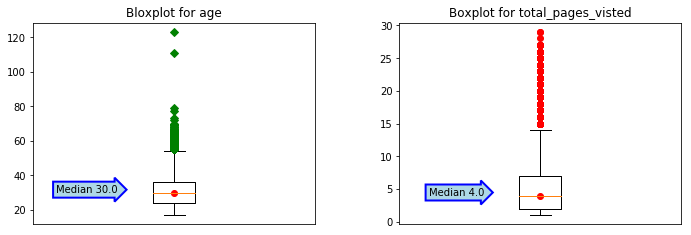

<Figure size 720x360 with 0 Axes>

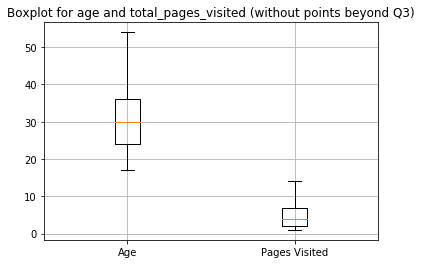

In [10]:
# hardcore boxplot - slight time consuming and seanborn.boxplot is a good substitution.
fig, axs = plt.subplots(1,2)
plt.figure(figsize = (10,5))
age = df["age"].values.tolist()
total_pages_visited = df["total_pages_visited"].values.tolist()


axs[0].boxplot(age, 0, 'gD')# change outlier point symbols
axs[0].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
axs[0].set_title('Bloxplot for age')

# annotate the median
axs[0].plot(1,median(age),'ro')
bbox_props = dict(boxstyle="rarrow,pad=0.3", ec="b", lw=2, fc="lightblue")
axs[0].text(1 - 0.2, median(age), "Median " + str(median(age)), bbox=bbox_props, ha="right")

axs[1].boxplot(total_pages_visited, 0, 'r')
axs[1].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
axs[1].set_title("Boxplot for total_pages_visted")

# annotate the median
axs[1].plot(1,median(total_pages_visited),'ro')
axs[1].text(1 - 0.2, median(total_pages_visited), "Median " + str(median(total_pages_visited)), bbox=bbox_props, ha="right")

fig.subplots_adjust(left=0.8, right=2.3, bottom=0.2, top=0.9,
                hspace=0.4, wspace=0.3)


# put all plots together
fig1, ax1 = plt.subplots()
ax1.set_title('Boxplot for age and total_pages_visited (without points beyond Q3)')
data = [age, total_pages_visited]
ax1.boxplot(data,0,'')
ax1.set_xticklabels(["Age", "Pages Visited"])
plt.grid()

Remove the examples with age above 80.

In [7]:
len(df)

316200

In [8]:
df = df.loc[(df["age"] < 80)]

In [9]:
len(df)

316198

In [10]:
# separate into two subsets for later analysis usage
converted = df[(df["converted"] == 1)]
not_converted = df[(df["converted"] == 0)]

Now let's look at the **categorical variables**

In [15]:
df.groupby("country").describe(include = "object")

source                   
          count unique  top   freq
country                           
China     76602      3  Seo  37578
Germany   13055      3  Seo   6431
UK        48449      3  Seo  23801
US       178092      3  Seo  87229

Most users are from US, with over 56% of the total sample size. US, China, and UK capture ~95% of the total sample size, with the rest user country origin being Germany.

In [16]:
df.groupby("source").describe(include = "object")

country                  
         count unique top   freq
source                          
Ads      88739      4  US  49901
Direct   72420      4  US  40962
Seo     155039      4  US  87229

Most users (~50%) came to the site by clicking on search results.  
Now, let's take a deeper look at these two categorical variables and their relationship with conversion rate. Let's start with **country**.

In [11]:
# to suppress warnings using sns
import warnings
warnings.filterwarnings('ignore')

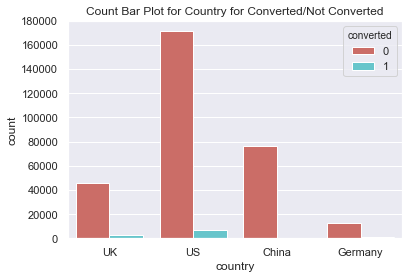

In [90]:
# https://seaborn.pydata.org/generated/seaborn.countplot.html
# https://seaborn.pydata.org/tutorial/color_palettes.html
sns.set(style="darkgrid")
ax = sns.countplot(x="country", hue="converted", data=df,palette = "hls").set_title("Count Bar Plot for Country for Converted/Not Converted")

In [13]:
pr_c = len(converted.groupby("country").get_group("China")) / len(converted)

In [14]:
pr_US = len(converted.groupby("country").get_group("US")) / len(converted)

In [15]:
print("Probability(X = China | Converted): ", round(pr_c,2))
print("Probability(X = US | Converted): ", round(pr_US,2))

Probability(X = China | Converted):  0.01
Probability(X = US | Converted):  0.66


For those who converted, they are most likely from US with the conditional probability of 0.66, and they are least likely to come from China, with the conditional prob of 0.01. However, we don't know for sure which country is more pruned to convert because US simply has larger population in this sample. So let's take an inverse conditional probability of four countries, respectively, to see which one of them is more pruned to convert.

In [18]:
pr_c_2 = len(converted.groupby("country").get_group("China")) / len(df.groupby("country").get_group("China"))

In [20]:
pr_us_2 = len(converted.groupby("country").get_group("US")) / len(df.groupby("country").get_group("US"))

In [21]:
pr_uk_2 = len(converted.groupby("country").get_group("UK")) / len(df.groupby("country").get_group("UK"))

In [22]:
pr_germany_2 = len(converted.groupby("country").get_group("Germany")) / len(df.groupby("country").get_group("Germany"))

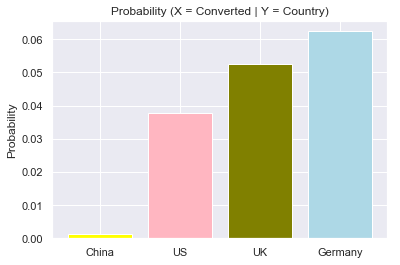

In [40]:
# https://python-graph-gallery.com/barplot/
height = [pr_c_2,pr_us_2,pr_uk_2, pr_germany_2]
bars = ('China', 'US', 'UK', 'Germany')
colors = ["yellow","lightpink","olive","lightblue"]
y_pos = np.arange(len(bars))

plt.bar(y_pos,height,color = colors)
plt.xticks(y_pos, bars)
plt.title("Probability (X = Converted | Y = Country)")
plt.ylabel("Probability")
plt.show() # supress messages

Now it seems that German users are pruned to convert, followed by British users, then is US, but Chinese are still significantly lower in conversion tendency.

Quick recap about country and its relationship with conversion rate:
    1. Of all the converted users, they are mostly from US and least from China
    2. Of all country origins, German users are most likely to be pruned to convert, and China is the least likely to be pruned to convert.  
Therefore, it seems that Chinese convert at a much lower rate than other countries!
    
What about **Source**?

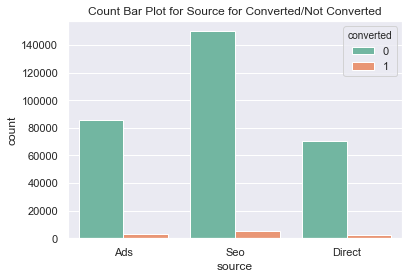

In [83]:
ax = sns.countplot(x="source", hue="converted", data=df,palette="Set2").set_title("Count Bar Plot for Source for Converted/Not Converted")

Seems like of those who converted are mostly users coming from search engines. But that could also due to more users are from search engines. So let's take an inverse conditional probability of these three sources, respectively, to see which one of them are more pruned to convert.

In [49]:
pr_seo = len(converted.groupby("source").get_group("Seo")) / len(df.groupby("source").get_group("Seo"))
pr_ads = len(converted.groupby("source").get_group("Ads")) / len(df.groupby("source").get_group("Ads"))
pr_d = len(converted.groupby("source").get_group("Direct")) / len(df.groupby("source").get_group("Direct"))

print("Probability(X = Converted | Search Result): ", round(pr_seo,4))
print("Probability(X = Converted | Clicking Ads): ", round(pr_ads,4))
print("Probability(X = Converted | Directly Typing URL): ", round(pr_d,4))

Probability(X = Converted | Search Result):  0.0329
Probability(X = Converted | Clicking Ads):  0.0345
Probability(X = Converted | Directly Typing URL):  0.0282


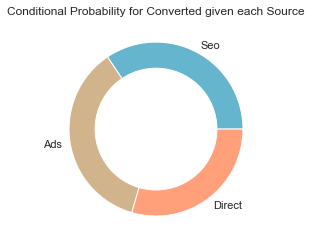

In [92]:
# Visualization in donut plot.
#For a clear visualization intention, bar > pie. If insist to use pie, many agree that donut plot is a better substitution.

#https://python-graph-gallery.com/donut-plot/
#https://python-graph-gallery.com/196-select-one-color-with-matplotlib/

# create data
names= ['Seo', 'Ads', 'Direct']
size=[pr_seo*100,pr_ads*100,pr_d*100]
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
# Give color names
plt.pie(size, labels=names,colors = ["c","tan","lightsalmon"])
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title("Conditional Probability for Converted given each Source")
plt.show()

Turns out that the probability of these three sources are all around 0.03 when it comes to conversion. So this could be an indicator that sources do not matter that much in terms of predicting user's conversion rate.

What about **new users**?

Recall that:  
\# of new users: 216744, proportion of total sample size: 68.55%.   
\# of existing users: 99454, proportion of total sample size: 31.45%.  
So most of the users ARE new users. How much proportion of the new users converted? 

In [98]:
new_user = df.groupby("new_user").get_group(1)
converted_new_user = len(new_user.loc[(new_user["converted"] == 1)])
not_converted_new_user = len(new_user.loc[(new_user["converted"] == 0)])
pr_con = round((converted_new_user / len(new_user)),2)
pr_no_con = round((not_converted_new_user / len(new_user)),2)

print("# of NEW USERS converted: {}, Probability(Converted | New User): {}"
      .format(converted_new_user,pr_con))
print("# of NEW USERS NOT converted: {}, Probability(Not Converted | New User): {}"
      .format(not_converted_new_user,pr_no_con))

# of NEW USERS converted: 3039, Probability(Converted | New User): 0.01
# of NEW USERS NOT converted: 213705, Probability(Not Converted | New User): 0.99


In [95]:
old_user = df.groupby("new_user").get_group(0)
converted_old_user = len(old_user.loc[(old_user["converted"] == 1)])
not_converted_old_user = len(old_user.loc[(old_user["converted"] == 0)])
pr_con_old = round((converted_old_user / len(old_user)),2)
pr_no_con_old = round((not_converted_old_user / len(old_user)),2)

print("# of EXISTING USERS converted: {}, Probability(Converted | EXISTING User): {}"
      .format(converted_old_user,pr_con_old))
print("# of EXISTING USERS NOT converted: {}, Probability(Not Converted | EXISTING User): {}"
      .format(not_converted_old_user,pr_no_con_old))

# of EXISTING USERS converted: 7159, Probability(Converted | EXISTING User): 0.07
# of EXISTING USERS NOT converted: 92295, Probability(Not Converted | EXISTING User): 0.93


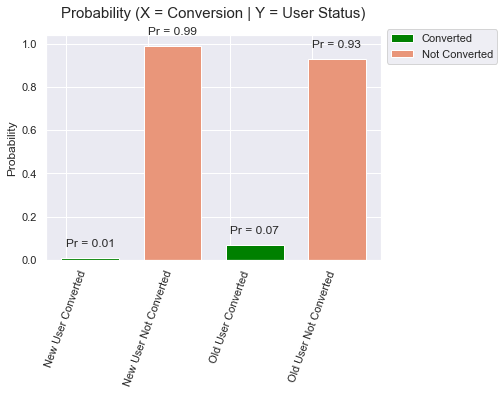

In [137]:
# visualization
# Create bars
barWidth = 0.7
bars1 = [pr_con,pr_con_old]
bars2 = [pr_no_con, pr_no_con_old]
bars4 = bars1 + bars2
 
# The X position of bars
r1 = [1,3]
r2 = [2,4]
r4 = r1+r2
 
# Create barplot
plt.bar(r1, bars1, width = barWidth, color = ("green"),label='Converted')
plt.bar(r2, bars2, width = barWidth, color = "darksalmon",label='Not Converted')
# Note: the barplot could be created easily. See the barplot section for other examples.
 
# Create legend
plt.legend(bbox_to_anchor=(1, 1.05))
 
# Text below each barplot with a rotation
plt.xticks([r + barWidth for r in range(len(r4))],
           ["New User Converted","New User Not Converted","Old User Converted","Old User Not Converted"], rotation=70)
 
# Create labels
label = ['Pr = 0.01', 'Pr = 0.07', 'Pr = 0.99', 'Pr = 0.93']
# Text on the top of each barplot
for i in range(len(r4)):
    plt.text(x = r4[i]-0.3 , y = bars4[i]+0.05, s = label[i], size = 12)


plt.subplots_adjust(bottom= 0.2, top = 0.98)
plt.ylabel("Probability")
plt.title("Probability (X = Conversion | Y = User Status)", fontsize = 15, y = 1.05)
# Show graphic
plt.show()

Thus, it seems like existing users are more pruned to convert than new users (0.07 > 0.01).  
We have some initial insights into categorical variables. What about continuous variables? How do they corelate with each other and the conversion rate?

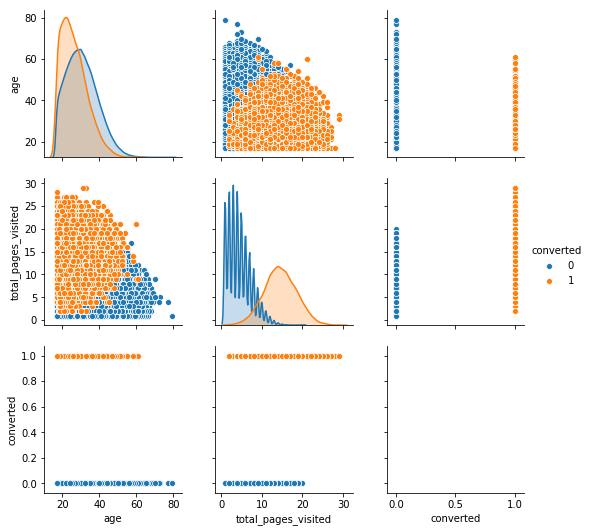

In [28]:
# https://seaborn.pydata.org/generated/seaborn.pairplot.html
# for all continuous variables
ax = sns.pairplot(df[(["age","total_pages_visited","converted"])], hue = 'converted')

First two rows on age and total pages visited have some interesting plots deserving some further look at. From the third row, we know that converted users have a lower age average, and have a higher average of total pages visited.

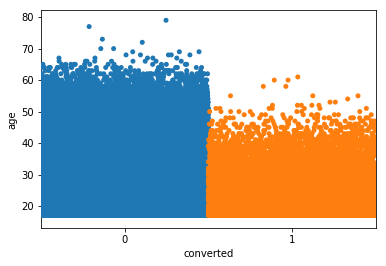

In [30]:
# closer look at some interesting plots

# seaborn.stripplot - draw scatterplot with one variable being categorical
ax = sns.stripplot(x = "converted", y = "age",data = df, jitter = 0.5)

For those who converted, most users are below 35. What about the total pages visited?

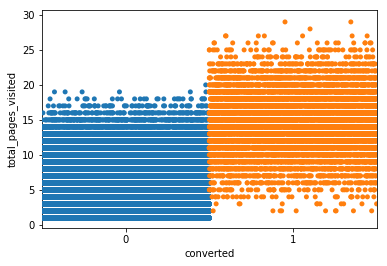

In [110]:
ax = sns.stripplot(x = "converted", y = "total_pages_visited",data = df, jitter = 0.5)

Seems like users whose total pages visited that are above 20 ALMOST ALWAYS CONVERT! At the same time, users with lower than 5 total pages visited BARELY CONVERT.  
But what about those users whose pages viewed are between 5 and 15? How can we distinguish them? Let's go further!

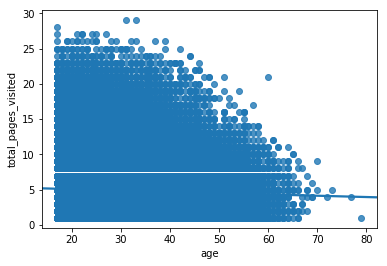

In [111]:
ax = sns.regplot(x="age", y="total_pages_visited", data = df)

It seems that the younger the user, the more total pages visited.

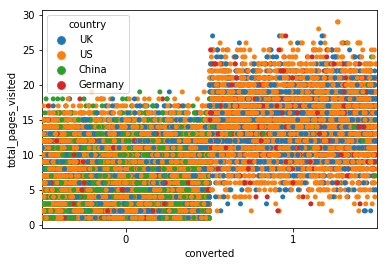

In [112]:
# nest the strips within a second categorical variable
ax = sns.stripplot(x = "converted", y = "total_pages_visited", hue = "country", data = df, jitter = 0.5)

Now we know that users who viewed 5~15 pages and converted are most likely from US, and somewhat likely from UK or Germany, but barely from China.

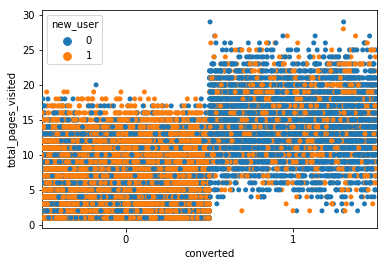

In [113]:
ax = sns.stripplot(x = "converted", y = "total_pages_visited", hue = "new_user", data = df, jitter = 0.5)

Similarly, the users who converted are mostly existing users.

### Summary of EDA:
Key findings:  
- for those converted users, US is the most popular country, with China being the least popular.
- of all country origins, German users are most likely to be pruned to convert, and China is the least likely to be pruned to convert.  
- Chinese convert at a much lower rate than other countries.
- sources do not matter that much in terms of predicting user's conversion rate because they are almost equal likely to be pruned to convert.
- existing users are more pruned to convert than new users.
- converted users have a lower age average, and have a higher average of total pages visited.
- for those users who convert, they are more likely to fall in the range of age between **20 to 45**.
- users whose total pages visited that are above 20 ALMOST ALWAYS CONVERT.
- users with lower than 5 total pages visited BARELY CONVERT.
- the younger the user, the more total pages visited.
- users who viewed 5~15 pages and converted are most likely from US, and somewhat likely from UK or Germany, but barely from China.
- Similarly, the users who converted are mostly existing users.


## Machine Learning
What's next to expect on modeling:  

    In supervised learning, a common strategy to overcome the class imbalance problem is to resample the original training dataset to decrease the overall level of class imbalance. Resampling is done either by increasing the minority class and/or decreasing majority class until the classes are approximately equally represented. I will first resample the dataset given that this is an imbalanced one.  

    Models I plan implement after resampling are, Random Forest, and Decision Tree. I am going to pick a Random Forest to predict conversion rate here. Reason for picking RF:  
    1. usually requires very little time to optimize it
    2. strong with outliers (we have not replaced all the outliers, only replaced the ones that are obviously wrong, because we don't want to eliminate potential important variables), irrelevant variables, continuous and discrete variables. 
    After I implemented the RF, I will evaluate the feature importance and implement a Decision Tree to validate my findings from RF. With more time I would spend ~1 day trying to find other models such as Gradient Boosting and pick the best from them.
    
Note from the book's solution:  
<mark>Pick the one you know the best. Don’t spend too much time optimizing it. Just explain why you picked it and say that with more time you would spend ~1 day trying other models/different params and you would pick the best.</mark>

### Prepare dataset 

In [147]:
# Feature Engineering
df = df.replace(["China","US","UK","Germany"],[0,1,2,3])

In [148]:
df = df.replace(["Ads","Seo","Direct"],[0,1,2])

In [149]:
converted = df[(df["converted"] == 1)]
not_converted = df[(df["converted"] == 0)]

In [150]:
# Resampling
from sklearn.utils import resample

In [151]:
# downsampling majority class
df_majority_downsample = resample(not_converted,
                                  n_samples = int((len(df) * 0.6)),
                                 replace=True,     
                                 random_state=123)  
print (len(df_majority_downsample))

189718


In [152]:
# upsampling minority class
df_minority_upsampled = resample(converted,
                                n_samples = int((len(df) * 0.4)),
                                 replace=True,     
                                 random_state=123)  

In [153]:
print (len(df_minority_upsampled))

126479


In [154]:
df_new = pd.concat([df_majority_downsample, df_minority_upsampled])

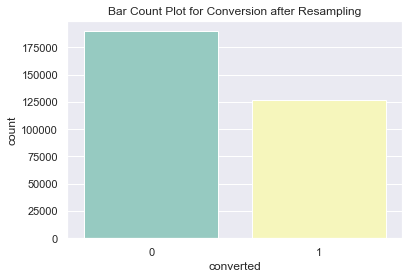

In [157]:
# what does the new dataset looks like
ax = sns.countplot(x = "converted", data = df_new, palette = "Set3").set_title("Bar Count Plot for Conversion after Resampling")

Partitioning into Training and Testing set. Here, I set the training : testing proportion as 75:25. 
<mark>if the data were too small, I would cross-validate</mark>

In [162]:
from sklearn.model_selection import train_test_split

In [163]:
df_train,df_test = train_test_split(df_new, test_size=0.25, random_state=42)

In [164]:
len(df_test)

79050

In [165]:
len(df_train)

237147

In [ ]:
# Build models

In [166]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

In [167]:
df_train.head()

,country,age,new_user,source,total_pages_visited,converted
288992,1,38,1,1,6,0
130535,1,34,1,0,5,0
151151,1,51,1,0,6,0
165256,1,30,1,0,4,0
50575,2,21,1,2,13,1


In [168]:
x_train = df_train[["country","age","new_user","source","total_pages_visited"]]

In [169]:
y_train = df_train["converted"]

In [170]:
x_test = df_test[["country","age","new_user","source","total_pages_visited"]]

In [171]:
y_test = df_test["converted"]

In [172]:
# train and test the model
rf = RandomForestClassifier(n_estimators=1000) # n_estimators = number of trees; default: 100
rf.fit(x_train , y_train)
y_pred = rf.predict(x_test)

In [173]:
y_pred

array([1, 0, 0, ..., 0, 0, 0])

In [237]:
# evaluation
# https://scikit-learn.org/stable/modules/model_evaluation.html
from sklearn.metrics import accuracy_score,classification_report
print("overall accuracy:", accuracy_score(y_pred,y_test))
target_names = ["converted","not converted"]
print("===Evaluatin Summary===")
print(classification_report(y_test, y_pred, target_names=target_names))

overall accuracy: 0.9554459203036053
===Evaluatin Summary===
               precision    recall  f1-score   support

    converted       0.97      0.96      0.96     47523
not converted       0.94      0.95      0.94     31527

     accuracy                           0.96     79050
    macro avg       0.95      0.95      0.95     79050
 weighted avg       0.96      0.96      0.96     79050



With an overall accuracy score of 0.95 on test set, the model itself is performing well without overfitting or underfitting.

Let's check the **variable importance**.

In [177]:
importances = rf.feature_importances_

In [178]:
importances

array([0.06504676, 0.06434757, 0.08661729, 0.00819805, 0.77579033])

In [180]:
std = np.std([rf.feature_importances_ for tree in rf.estimators_],
             axis=0)

In [181]:
std

array([6.24500451e-16, 4.16333634e-17, 9.02056208e-16, 1.14491749e-16,
       6.99440506e-15])

In [184]:
indices = np.argsort(importances)[::-1]

In [196]:
feature_names = list(x_train)

In [199]:
feature_names

['country', 'age', 'new_user', 'source', 'total_pages_visited']

In [201]:
# Print the feature ranking
print("Feature ranking:")

for index,f in enumerate(indices):
    print("%d. feature %s (%f)" % (index + 1, feature_names[f], importances[indices[index]]))

Feature ranking:
1. feature total_pages_visited (0.775790)
2. feature new_user (0.086617)
3. feature country (0.065047)
4. feature age (0.064348)
5. feature source (0.008198)


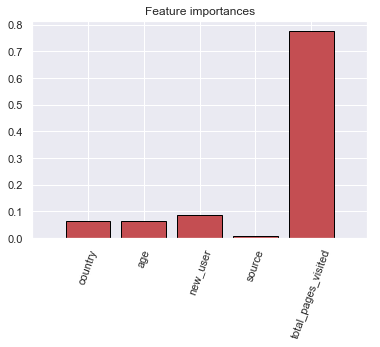

In [221]:
# Plot the feature importances of the forest
plt.title("Feature importances")
bars = importances
r1 = np.arange(len(bars))
yer1 = std # to small to show in this case

plt.bar(r1, bars,color="r", edgecolor = "black", yerr=yer1, align="center")
plt.xticks(range(len(feature_names)), feature_names, rotation = 70)
plt.xlim([-1, x_train.shape[1]])
plt.show()

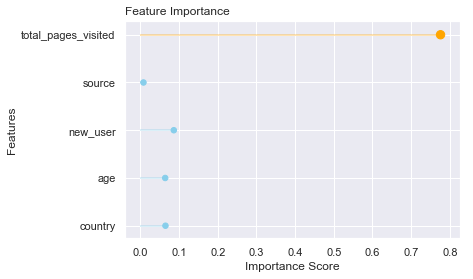

In [235]:
# Lolipop visualization 
ordered_df = importances
r1 = np.arange(len(bars))

# Create a color if the importance is greater than a threashold
my_color=np.where(ordered_df>0.5, 'orange', 'skyblue')
my_size=np.where(ordered_df > 0.5, 70, 30)
 
# The vertival plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
import seaborn as sns
plt.hlines(y=r1, xmin=0, xmax=ordered_df, color=my_color, alpha=0.4)
plt.scatter(ordered_df, r1, color=my_color, s=my_size, alpha=1)
 
# Add title and exis names
plt.yticks(r1, feature_names)
plt.title("Feature Importance", loc='left')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

 So we know that total pages visited is the most important feature among all features when it comes to predicting conversion rate.  
   <mark>Notes from the book:</mark>  
    Unfortunately, it (pages visited) is probably **the least “actionable”**. People visit many pages cause they already want to buy. Also, in order to buy you have to click on multiple pages.

So now let's rebuild the model without this feature and re-evaluate the feature importance

In [239]:
# partition into example and label set
x_train = df_train[["country","age","new_user","source"]]
y_train = df_train["converted"]

x_test = df_test[["country","age","new_user","source"]]
y_test = df_test["converted"]

In [240]:
# train and test the model
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(x_train , y_train)
y_pred = rf.predict(x_test)

In [247]:
# evaluation
# https://scikit-learn.org/stable/modules/model_evaluation.html
from sklearn.metrics import accuracy_score,classification_report
print("random forest mean accuracy on the given test data and labels:", rf.score(x_test,y_test))
target_names = ["converted","not converted"]
print("===Evaluatin Summary===")
print(classification_report(y_test, y_pred, target_names=target_names))

random forest mean accuracy on the given test data and labels: 0.7534218848829854
===Evaluatin Summary===
               precision    recall  f1-score   support

    converted       0.78      0.81      0.80     47523
not converted       0.70      0.66      0.68     31527

     accuracy                           0.75     79050
    macro avg       0.74      0.74      0.74     79050
 weighted avg       0.75      0.75      0.75     79050



Now the accuracy went down, but not bad. We can still gain insights from variables.

In [241]:
# check the feature importance again
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = list(x_train)

In [242]:
# Print the feature ranking
print("Feature ranking:")

for index,f in enumerate(indices):
    print("%d. feature %s (%f)" % (index + 1, feature_names[f], importances[indices[index]]))

Feature ranking:
1. feature new_user (0.468125)
2. feature country (0.325369)
3. feature age (0.197188)
4. feature source (0.009318)


In [261]:
feature_sorted

['new_user', 'country', 'age', 'source']

<mark>Notes on sort</mark>  
three sorting algorithm used by numpy.sort:

kind 	speed 	worst case 	work space 	stable

‘quicksort’ 	1 	O(n^2) 	0 	no

‘mergesort’ 	2 	O(n*log(n)) 	~n/2 	yes

‘heapsort’ 	3 	O(n*log(n)) 	0 	no

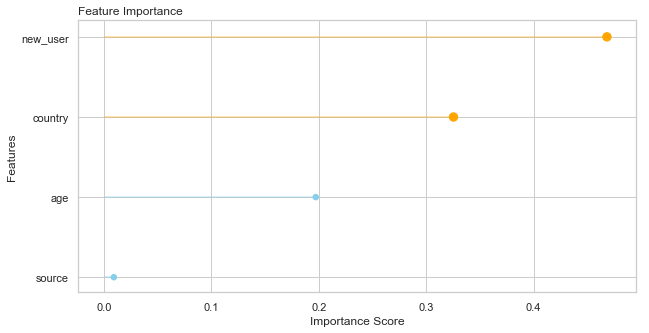

In [275]:
# Lolipop visualization 
# style : dict, None, or one of {darkgrid, whitegrid, dark, white, ticks}
sns.set_style("whitegrid")
# build sorted data
ordered_df = np.sort(importances)
r1 = np.arange(len(ordered_df))
feature_sorted = []
for f in indices:
    feature_sorted.append(feature_names[f])
feature_sorted = feature_sorted[::-1]
    
# Create a color if the importance is greater than a threashold
my_color=np.where(ordered_df>0.3, 'orange', 'skyblue')
my_size=np.where(ordered_df > 0.3, 70, 30)
 
# The vertival plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
import seaborn as sns
plt.figure(figsize = (10,5))
plt.hlines(y=r1, xmin=0, xmax=ordered_df, color=my_color, alpha=0.4)
plt.scatter(ordered_df, r1, color=my_color, s=my_size, alpha=1)
 
# Add title and exis names
# for index,f in enumerate(indices):
plt.yticks(r1, feature_sorted)

plt.title("Feature Importance", loc='left')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

Interesting! So now we know that new user and country are two most important but also actionable features, while source being the most insignificant variable in predicting the conversion rate.

Now let's build a decision tree to confirm our findings, with only important and actionable features.

In [277]:
x_train = df_train[["new_user","country","age"]]
y_train = df_train["converted"]

x_test = df_test[["new_user","country","age"]]
y_test = df_test["converted"]

In [276]:
# Decision Tree
from sklearn import tree

In [281]:
dt = tree.DecisionTreeClassifier(max_depth = 3)

[Text(167.4, 190.26, 'X[0] <= 0.5\nentropy = 0.48\nsamples = 237147\nvalue = [142195, 94952]'),
 Text(83.7, 135.9, 'X[1] <= 0.5\nentropy = 0.476\nsamples = 109484\nvalue = [42630, 66854]'),
 Text(41.85, 81.53999999999999, 'X[2] <= 31.5\nentropy = 0.102\nsamples = 11246\nvalue = [10641, 605]'),
 Text(20.925, 27.180000000000007, 'entropy = 0.147\nsamples = 6480\nvalue = [5963, 517]'),
 Text(62.775000000000006, 27.180000000000007, 'entropy = 0.036\nsamples = 4766\nvalue = [4678, 88]'),
 Text(125.55000000000001, 81.53999999999999, 'X[2] <= 31.5\nentropy = 0.439\nsamples = 98238\nvalue = [31989, 66249]'),
 Text(104.625, 27.180000000000007, 'entropy = 0.385\nsamples = 70141\nvalue = [18263, 51878]'),
 Text(146.475, 27.180000000000007, 'entropy = 0.5\nsamples = 28097\nvalue = [13726, 14371]'),
 Text(251.10000000000002, 135.9, 'X[1] <= 0.5\nentropy = 0.343\nsamples = 127663\nvalue = [99565, 28098]'),
 Text(209.25, 81.53999999999999, 'X[2] <= 33.5\nentropy = 0.026\nsamples = 25436\nvalue = [251

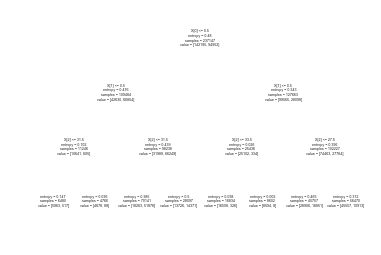

In [282]:
tree.plot_tree(dt.fit(x_train, y_train)) 

In [285]:
from sklearn.tree.export import export_text
decision_tree = tree.DecisionTreeClassifier(random_state=0, max_depth=3)
decision_tree = decision_tree.fit(x_train, y_train)
r = export_text(decision_tree, feature_names=list(x_train))
print(r)

|--- new_user <= 0.50
|   |--- country <= 0.50
|   |   |--- age <= 31.50
|   |   |   |--- class: 0
|   |   |--- age >  31.50
|   |   |   |--- class: 0
|   |--- country >  0.50
|   |   |--- age <= 31.50
|   |   |   |--- class: 1
|   |   |--- age >  31.50
|   |   |   |--- class: 1
|--- new_user >  0.50
|   |--- country <= 0.50
|   |   |--- age <= 33.50
|   |   |   |--- class: 0
|   |   |--- age >  33.50
|   |   |   |--- class: 0
|   |--- country >  0.50
|   |   |--- age <= 27.50
|   |   |   |--- class: 0
|   |   |--- age >  27.50
|   |   |   |--- class: 0



In [289]:
# evaluation
print("overall accuracy on decision tree:", decision_tree.score(x_test,y_test))

overall accuracy on decision tree: 0.7419228336495889


## Conclusion
### Business insights
Although total number of pages visited is a very important feature when it comes to predicting the conversion rate, it is not a very actionable feature because users need to click more pages if he/she want to buy certain product. Also, sources do not matter that much in terms of predicting user's conversion rate because all sources are almost equal likely to be pruned to convert.  
Therefore, conversion rate is greatly depend on the user status of whether he/she is a new user or not, followed by the country origin, and user age. 
- Existing users are more pruned to convert than new users.  
- China has the least user conversion rate.  
- German users are more pruned to convert than UK and US.  
- Younger users (<35) are more pruned to convert.

#### Recommendations
- Since China has a significantly lower tendency to convert than other three countries, it is possible that the Chinese translation of the site is not appealing or accurate enough. Product team could use this finding to improve the site translation and more catered toward Chinese users. On the other hand, the bad performance in China can also due to the lack of advertising in Chinese market. Therefore, marketing team could put more effort into improving the market awareness in China.    
- The site is working very well for young users. Definitely let’s tell marketing to advertise and use
marketing channel which are more likely to reach young people.  
- The site is working very well for Germany in terms of conversion. But the summary showed that
there are few Germans coming to the site: way less than UK, despite a larger population. Again,
marketing should get more Germans. Big opportunity.  
- Users with old accounts do much better. Targeted emails with offers to bring them back to the site
could be a good idea to try.  
- Something is wrong with the Chinese version of the site. It is either poorly translated, doesn’t fit the
local culture, some payment issue or maybe it is just in English! Given how many users are based in
China, fixing this should be a top priority. Huge opportunity.  
- Maybe go through the UI and figure out why older users perform so poorly? From 30 y/o conversion
clearly starts dropping.  
- If I know someone has visited many pages, but hasn’t converted, she almost surely has high
purchase intent. I could email her targeted offers or sending her reminders. Overall, these are
probably the easiest users to make convert.  


<mark>Notes from the book</mark>
As you can see, conclusions usually end up being about:  
1. tell marketing to get more of the good performing user segments  
2. tell product to fix the experience for the bad performing ones